## Notebook to compare FOUNDIN-PD da65 SCRN-DA and HipSci day 52 SCRN-DA eQTL; also FOUNID RNAB and HipSci SCRN pseudo bulk  

Jerber J, Seaton DD, Cuomo ASE et al. Population-scale single-cell RNA-seq profiling across dopaminergic neuron differentiation. Nat Genet 2021;53:304–12. 
https://pubmed.ncbi.nlm.nih.gov/33664506/



In [1]:
!date

Fri Jan 20 15:16:05 UTC 2023


#### import libraries

In [2]:
from dask.dataframe import read_csv as dask_read_csv
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf
from pandas import DataFrame, Series, concat

import matplotlib.pyplot as plt
from seaborn import scatterplot
from matplotlib.pyplot import rc_context

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming

# directories 
wrk_dir = '/home/jupyter/foundin_qtl'
meta_dir = f'{wrk_dir}/meta'

# in files
foundin_files = f'{meta_dir}/foundin_da65_SCRN-DA.*.metal_in.csv.gz'
hipsci_files = f'{meta_dir}/hipsci_D52_DA.*.metal_in.csv.gz'

# out files

# variables
DEBUG = False
alpha = 0.05

#### utility functions

In [4]:
# compute B&H FDR for given p-values
def compute_fdr(pvalues):
    bh_adj = smm.fdrcorrection(pvalues)
    return bh_adj[1]

def read_metal_results(files_path: str, label: str, col_corrects: dict, verbose: bool=False) -> DataFrame:
    meta_dd = dask_read_csv(files_path)
    # go ahead and convert from dask to pandas data frame
    meta_df = meta_dd.compute()
    # if colnames renames provided then apply
    if col_corrects:
        meta_df = meta_df.rename(columns=col_corrects)
    print(f'{label} meta results shape {meta_df.shape}')
    if verbose:
        display(meta_df.head())
    return meta_df

def get_tops(qtl_df: DataFrame, label: str, trait_col: str, verbose: bool=False):
    # get top result per trait with a significant result
    tops_df = qtl_df.sort_values('bh_fdr').drop_duplicates([trait_col], keep='first')
    print(f'{label} shape of just the top hits for each trait QTL {tops_df.shape}')
    if DEBUG:
        display(tops_df.head())
    return tops_df

def ensure_matched_indices(df1: DataFrame, df2: DataFrame) -> {DataFrame, DataFrame}:
    """ make sure the two datasets are ordered the same
        modifies both df1 and df2
    Args:
        df1 (pandas.DataFrame) risk or trait1 data
        df2 (pandas.DataFrame) qtl or trait2 data
    """ 
    # ensure that the risk and feature variants ABF's are ordered the same
    df1 = df1.set_index('qtl_pair')
    df2 = df2.set_index('qtl_pair')
    print('reindexing')
    shared_indices = df1.index.intersection(df2.index)
    df1 = df1.loc[shared_indices,]
    df2 = df2.loc[shared_indices,]
    temp = df1.index.values == df2.index.values
    display(Series(temp).value_counts())
    return df1, df2

def regress_features(df: DataFrame, endo_var: str, exo_var: str):
    this_formula = f'{exo_var} ~ {endo_var}'
    reg_model = smf.ols(this_formula, data=df).fit()
    print(reg_model.summary())
    print(['coef', 'stderr', 'r2adj', 'term_cnt', 'p-value'])
    print(reg_model.params[endo_var], reg_model.bse[endo_var], reg_model.rsquared_adj,
          reg_model.params.shape[0], reg_model.pvalues[endo_var])
    
def plot_similarity(df: DataFrame, x_var: str, y_var: str):
    with rc_context({'figure.figsize': (8, 8), 'figure.dpi': 100}):
        plt.style.use('seaborn-bright')
        figure = scatterplot(x=x_var, y=y_var, data=df, palette='Set1')
        figure.axhline(0, color='black', zorder=0)
        figure.axvline(0, color='black', zorder=0)
        plt.show()

def check_similarity(df1: DataFrame, df2: DataFrame, 
                     label1: str, label2: str, feature: str,
                     verbose: bool=False) -> DataFrame:
    # create a combined df
    reg_df = concat([df1.beta, df1.score, df2.beta, df2.score], axis=1)
    reg_df.columns = [f'{label1}_beta', f'{label1}_score', 
                      f'{label2}_beta', f'{label2}_score']
    print(reg_df.shape)
    regress_features(reg_df, f'{label1}_{feature}', f'{label2}_{feature}')
    plot_similarity(reg_df, f'{label1}_{feature}', f'{label2}_{feature}')
    if DEBUG:
        display(reg_df.head())
    return reg_df
        
def correct_effect_alleles(df1: DataFrame, df2: DataFrame, 
                           verbose: bool=False) -> {DataFrame, DataFrame}:
    # check and correct for effect-allele swaps
    temp = df2.effect_allele == df1.other_allele
    swapped_idx = temp[temp == True].index
    # for id'ed swaps flip the alleles
    df1.loc[swapped_idx,['effect_allele','other_allele']] = df1.loc[swapped_idx,['other_allele','effect_allele']].values
    # for the flipped alleles also flip the direction of effect
    df1.loc[swapped_idx, ['beta']] = df1.loc[swapped_idx, ['beta']]*-1
    if DEBUG:
        display(Series(temp).value_counts())
    # after correcting detected flips, remove any that still don't match
    temp = df1.effect_allele != df2.effect_allele
    mismatch_idx = temp[temp == True].index
    display(Series(temp).value_counts())
    df1 = df1.drop(index=mismatch_idx)
    df2 = df2.drop(index=mismatch_idx)
    print(df1.shape)
    print(df2.shape)
    if DEBUG:
        display(Series(temp).value_counts()) 
        temp = df1.effect_allele == df2.effect_allele
        display(Series(temp).value_counts())  
        
def compare_results(df1: DataFrame, df2: DataFrame, 
                    label1: str, label2: str, pairs: set, 
                    verbose: bool=False) -> DataFrame:
    # subset from the full set of possible
    set1_df = df1.loc[df1.qtl_pair.isin(pairs)]
    set2_df = df2.loc[df2.qtl_pair.isin(pairs)]
    print(set1_df.shape)
    print(set2_df.shape)

    # make sure they have same indices prior to combining
    set1_df, set2_df = ensure_matched_indices(set1_df, set2_df)
    correct_effect_alleles(set1_df, set2_df)
    # add regression scores
    set1_df['score'] = set1_df.beta/set1_df.se
    set2_df['score'] = set2_df.beta/set2_df.se
    # check the similarity by beta
    check_similarity(set1_df, set2_df, label1, label2, 'beta')
    # check the similarity by score
    ret_df = check_similarity(set1_df, set2_df, label1, label2, 'score')    
    if DEBUG:
        display(set1_df.head())
        display(set2_df.head())        
    return ret_df

### load data

will use the files prepped for metal analysis with Metal since they will have similar formatting

#### load FOUNDIN-PD da65 SCRN-DA eQTL

In [5]:
%%time
# keeping kosoy columns as is, so empty dict
foundin_cols_rename_dict = {'slope': 'beta', 'slope_se': 'se', 
                            'pval_nominal': 'pvalue', 'phenotype_id': 'trait', 
                            'variant_id': 'variant'}
foundin_df = read_metal_results(foundin_files, 'foundin', foundin_cols_rename_dict, 
                              verbose=DEBUG)

/opt/conda/lib/python3.7/site-packages/dask/dataframe/io/csv.py:533: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression


foundin meta results shape (44942481, 8)
CPU times: user 1min 54s, sys: 40.5 s, total: 2min 35s
Wall time: 1min 20s


#### load the HipSci day 52 SCRN-DA untreated eQTL

In [6]:
%%time
hipsci_cols_rename_dict = {'p_value': 'pvalue', 'feature_name': 'trait',
                           'beta_se': 'se', 'variant_id': 'variant'}
hipsci_df = read_metal_results(hipsci_files, 'hipsci', hipsci_cols_rename_dict, 
                             verbose=DEBUG)

/opt/conda/lib/python3.7/site-packages/dask/dataframe/io/csv.py:533: UserWarning: Warning gzip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression


hipsci meta results shape (25520513, 12)
CPU times: user 1min 34s, sys: 36 s, total: 2min 10s
Wall time: 57.6 s


### apply FDR correction

In [7]:
%%time
foundin_df['bh_fdr'] = compute_fdr(foundin_df['pvalue'].fillna(1))
hipsci_df['bh_fdr'] = compute_fdr(hipsci_df['pvalue'].fillna(1))

if DEBUG:
    print(foundin_df.shape)
    print(hipsci_df.shape)
    display(foundin_df.head())
    display(hipsci_df.head())

CPU times: user 16.5 s, sys: 269 ms, total: 16.7 s
Wall time: 16.7 s


### Compare FOUNDIN with HipSci

#### subset to all pairs tested in both

In [8]:
%%time
full_pairs = set(hipsci_df.qtl_pair) & set(foundin_df.qtl_pair)
print(f'{len(full_pairs)} QTL pairs found in both FOUNDIN-PD and HipSci')
hipsci_temp_df = hipsci_df.loc[hipsci_df.qtl_pair.isin(full_pairs)]
foundin_temp_df = foundin_df.loc[foundin_df.qtl_pair.isin(full_pairs)]
print(f'temp HipSci shape {hipsci_temp_df.shape}')
print(f'temp FOUNDIN shape {foundin_temp_df.shape}')

17599639 QTL pairs found in both FOUNDIN-PD and HipSci
temp HipSci shape (17599639, 13)
temp FOUNDIN shape (17599639, 9)
CPU times: user 1min 18s, sys: 399 ms, total: 1min 19s
Wall time: 1min 18s


#### get top QTL variant per trait

In [9]:
%%time
foundin_tops_df = get_tops(foundin_temp_df.loc[foundin_temp_df.bh_fdr <= alpha], 
                           'foundin', 'trait', verbose=DEBUG)
hipsci_tops_df = get_tops(hipsci_temp_df.loc[hipsci_temp_df.bh_fdr <= alpha], 
                          'hipsci', 'trait', verbose=DEBUG)

foundin shape of just the top hits for each trait QTL (368, 9)
hipsci shape of just the top hits for each trait QTL (3992, 13)
CPU times: user 168 ms, sys: 0 ns, total: 168 ms
Wall time: 166 ms


In [10]:
top_pairs = set(foundin_tops_df.qtl_pair) | set(hipsci_tops_df.qtl_pair)
print(f'{len(top_pairs)} QTL pairs found for inclusion between FOUNDIN and HipSci')

4340 QTL pairs found for inclusion between FOUNDIN and HipSci


#### how many feature QTL intersect between cohorts

In [13]:
intersecting_traits = set(foundin_tops_df.trait) & set(hipsci_tops_df.trait)
print(f'{len(intersecting_traits)} features with QTL present in both FOUNDIN and HipSci')

275 features with QTL present in both FOUNDIN and HipSci


(4340, 13)
(4340, 9)
reindexing


True    4340
dtype: int64

False    4334
True        6
Name: effect_allele, dtype: int64

(4334, 12)
(4334, 8)
(4340, 4)
                            OLS Regression Results                            
Dep. Variable:           FOUNDIN_beta   R-squared:                       0.251
Model:                            OLS   Adj. R-squared:                  0.250
Method:                 Least Squares   F-statistic:                     1450.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):          5.25e-274
Time:                        15:22:53   Log-Likelihood:                 7171.7
No. Observations:                4340   AIC:                        -1.434e+04
Df Residuals:                    4338   BIC:                        -1.433e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


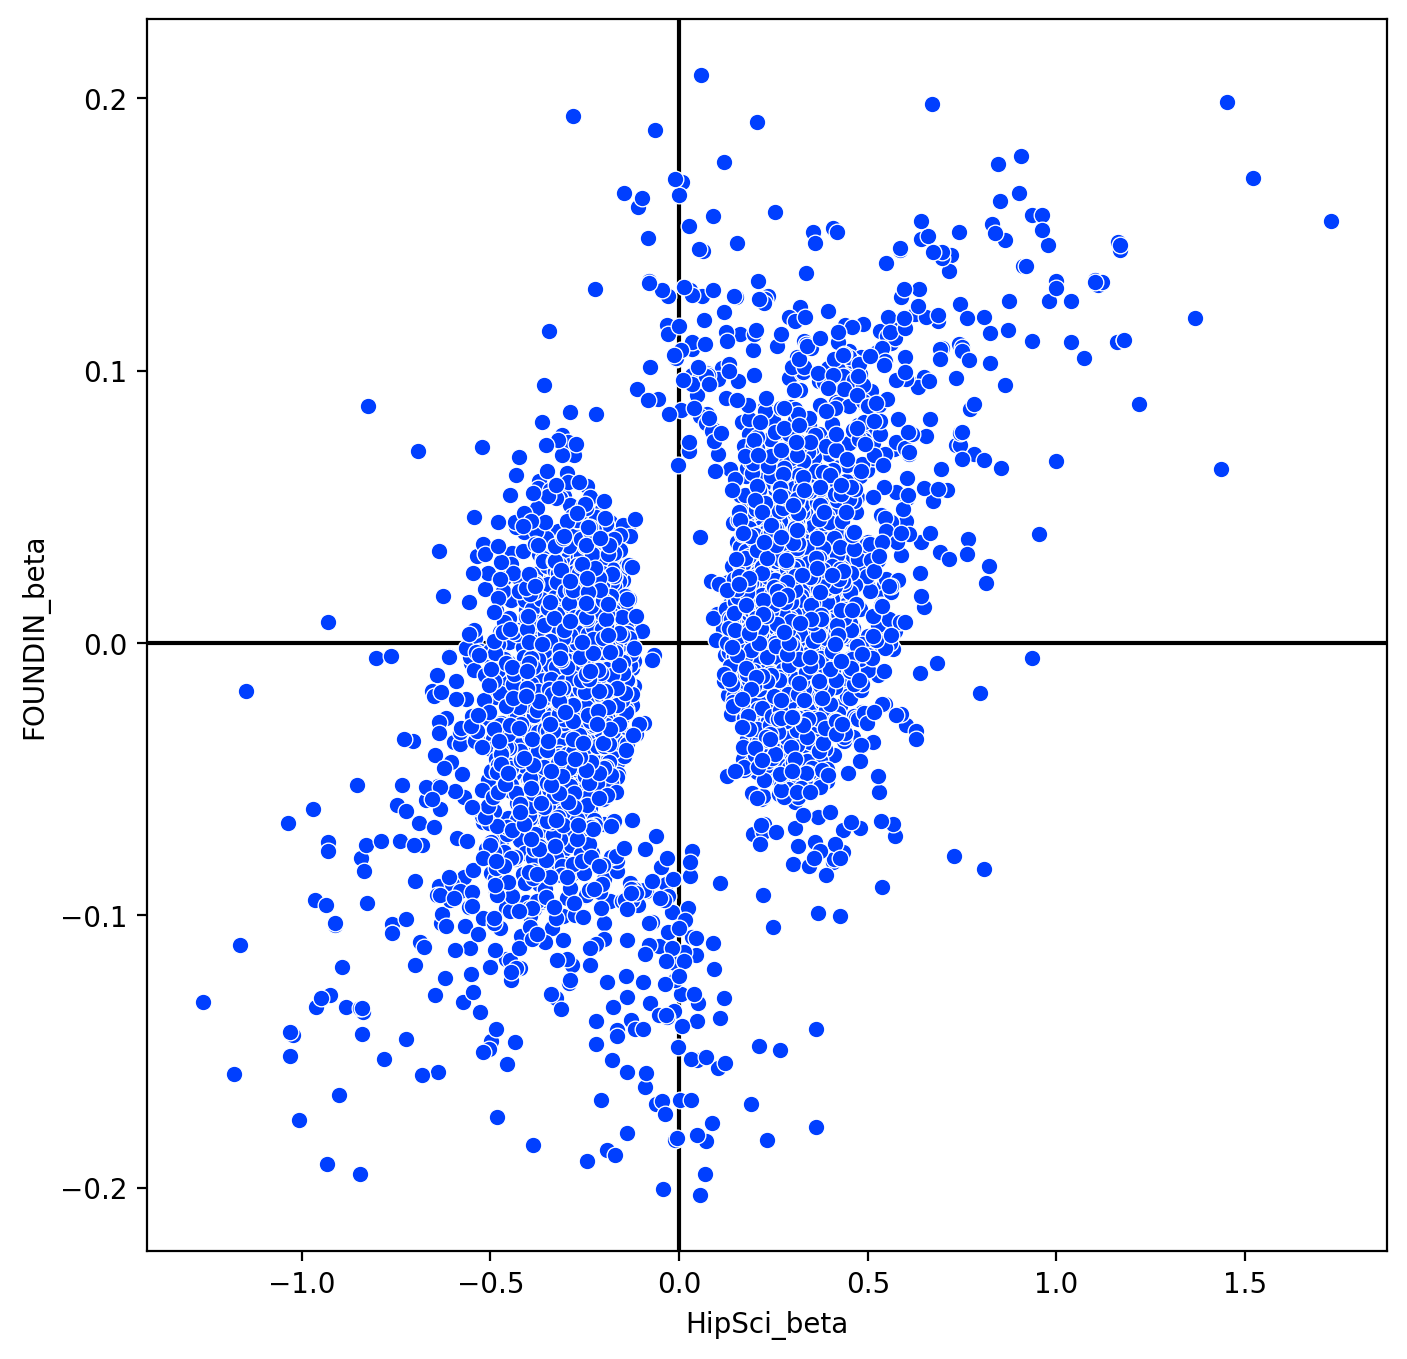

(4340, 4)
                            OLS Regression Results                            
Dep. Variable:          FOUNDIN_score   R-squared:                       0.289
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     1761.
Date:                Fri, 20 Jan 2023   Prob (F-statistic):          1.98e-323
Time:                        15:22:55   Log-Likelihood:                -8979.1
No. Observations:                4340   AIC:                         1.796e+04
Df Residuals:                    4338   BIC:                         1.797e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0734      0.029    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.


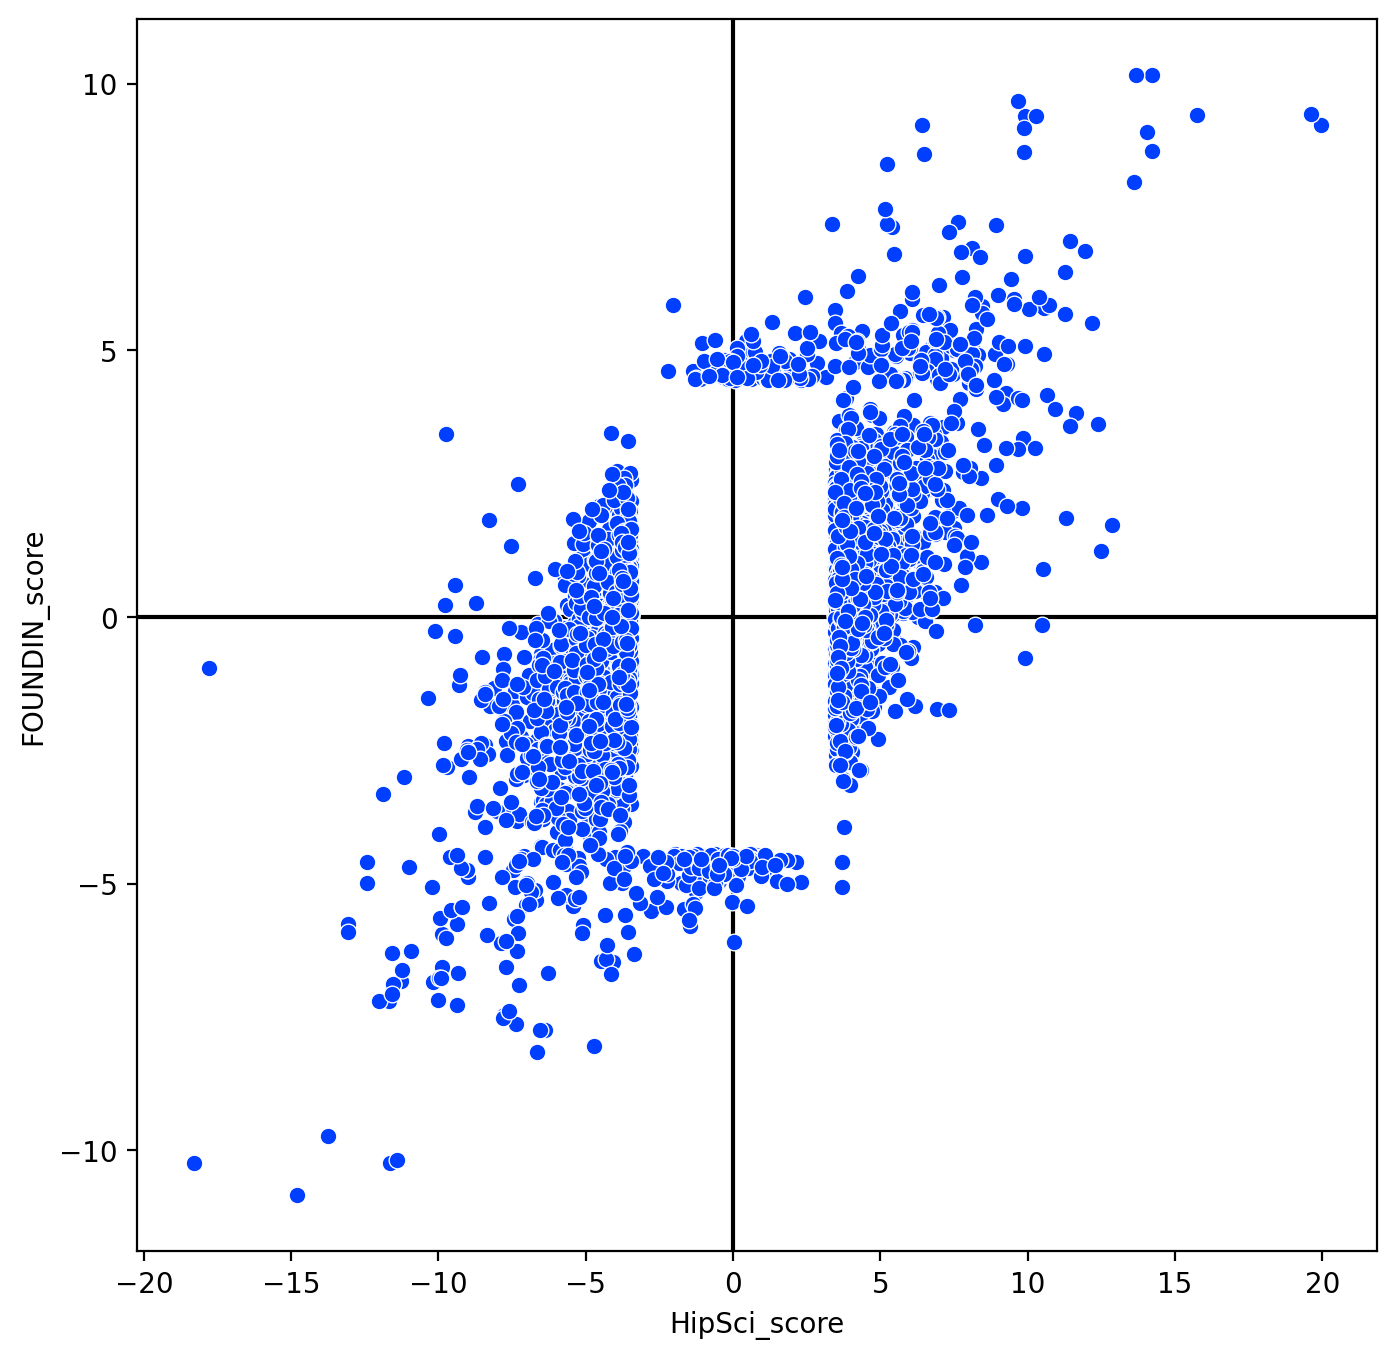

CPU times: user 7.12 s, sys: 2.2 s, total: 9.32 s
Wall time: 5.3 s


,HipSci_beta,HipSci_score,FOUNDIN_beta,FOUNDIN_score
qtl_pair,,,,
MIB2:rs9442360,-0.166120,-3.996063,0.020310,1.000940
B3GALT6:rs944369,0.164920,3.615495,-0.024087,-0.930782
ACAP3:rs1781136,0.324813,3.649431,0.030692,0.745763
CDK11A:rs56044478,-0.413508,-3.817632,-0.067112,-1.551186
SLC35E2A:rs7542410,0.592705,6.865781,0.041100,1.879893
...,...,...,...,...
DPP7:rs10870177,0.224148,4.789352,0.036980,1.577079
FBXW5:rs7032504,0.126742,3.701372,0.019417,0.706496
SSNA1:rs79470506,0.269210,3.654762,0.038867,0.969179


In [14]:
%%time
compare_results(hipsci_temp_df, foundin_temp_df, 'HipSci', 'FOUNDIN', top_pairs, 
                verbose=DEBUG)

In [15]:
!date

Fri Jan 20 15:22:56 UTC 2023
